<a href="https://colab.research.google.com/github/manikur/R-programming/blob/main/Sbin_ns_stock_price_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 11.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=bdabef51fe8d0a20b56a12d8e57fb07dd6063e3460cb27ead2e61df06724c8c7
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
import numpy as np
import os
import random
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import (Dataset, TensorDataset,
 DataLoader, Subset)
from collections import OrderedDict
from sklearn.metrics import mean_squared_error

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df = yf.download('SBIN.NS',
 start='2010-01-01',
 end='2021-09-08',
 adjusted=True,
 progress=False)

In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-01,427.500000,432.549988,425.149994,429.899994,429.899994,18776721
2021-09-02,431.399994,433.500000,427.750000,429.750000,429.750000,14372717
2021-09-03,431.250000,434.299988,428.200012,431.399994,431.399994,14233624
2021-09-06,432.000000,433.850006,430.049988,431.049988,431.049988,10694099
2021-09-07,431.049988,431.700012,425.100006,429.100006,429.100006,14928735


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2.880000e+03
mean,254.076248,257.398712,250.310102,253.677137,243.697820,2.596472e+07
std,58.420941,58.973732,57.694784,58.337995,60.825930,2.014613e+07
min,147.000000,148.490005,145.270004,147.360001,138.993088,0.000000e+00
25%,208.781250,211.727497,206.232494,209.135002,194.943405,1.419982e+07
50%,253.000000,255.974998,249.184998,252.354996,242.257614,1.972750e+07
75%,287.950012,290.812492,283.200012,286.850006,280.498840,3.020477e+07
max,461.000000,467.450012,441.500000,456.950012,456.950012,2.626771e+08


In [ ]:
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'price'}, inplace=True)
df = df.resample('M').last()

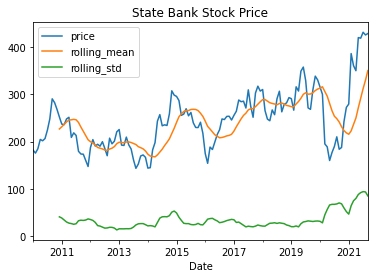

In [ ]:
WINDOW_SIZE = 12
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df.plot(title='State Bank Stock Price')

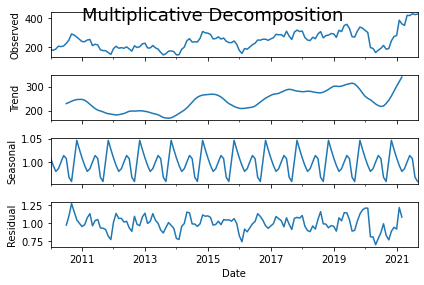

In [ ]:
decomposition_results = seasonal_decompose(df.price,
 model='multiplicative')
decomposition_results.plot() \
 .suptitle('Multiplicative Decomposition',
 fontsize=18);

In [ ]:
import pandas as pd
import seaborn as sns
from fbprophet import Prophet

In [ ]:
df = yf.download('SBIN.NS',
 start='2010-01-01',
 end='2021-09-08',
 adjusted=True,
 progress=False)

In [ ]:
df = df.loc[:, ['Adj Close']]

In [ ]:
df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

In [ ]:
train_indices = df.ds.apply(lambda x: x.year) < 2021
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)

In [ ]:
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5,fourier_order=5)
model_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


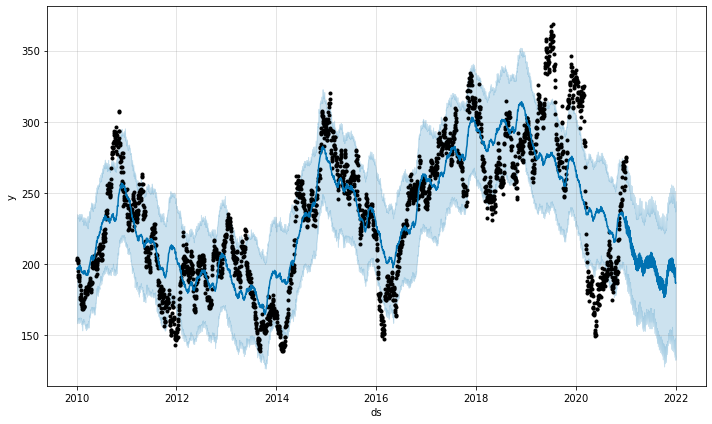

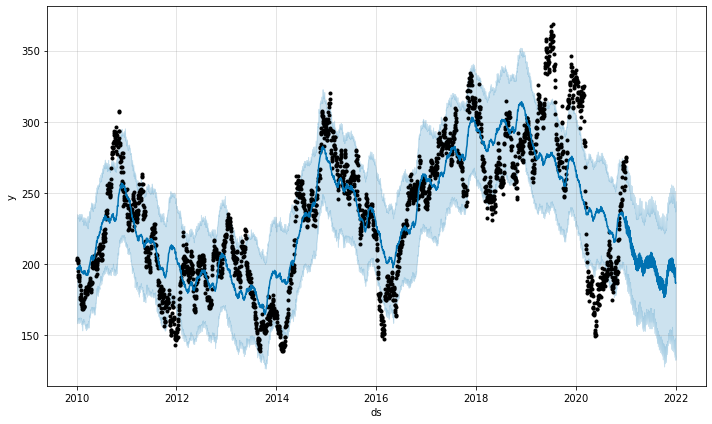

In [ ]:
df_future = model_prophet.make_future_dataframe(periods=365)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred)

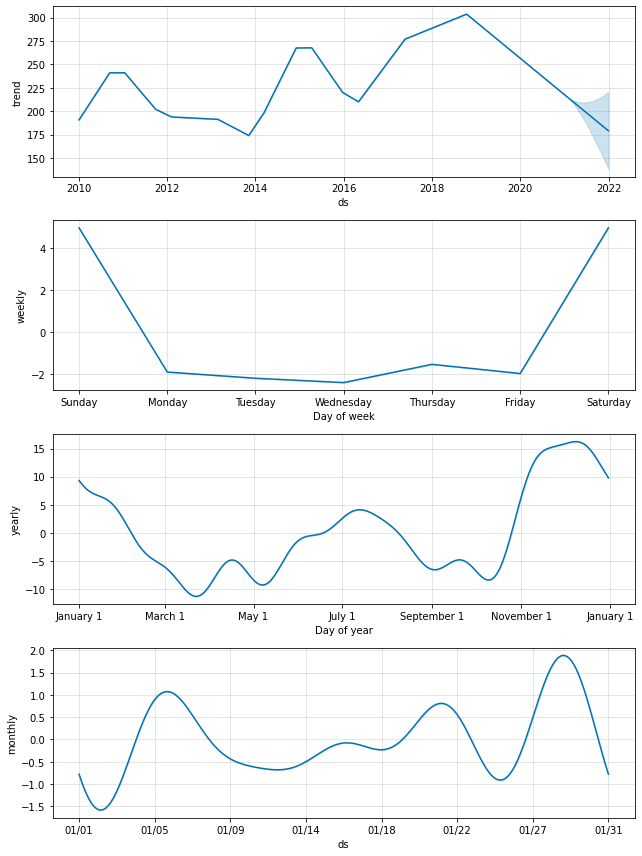

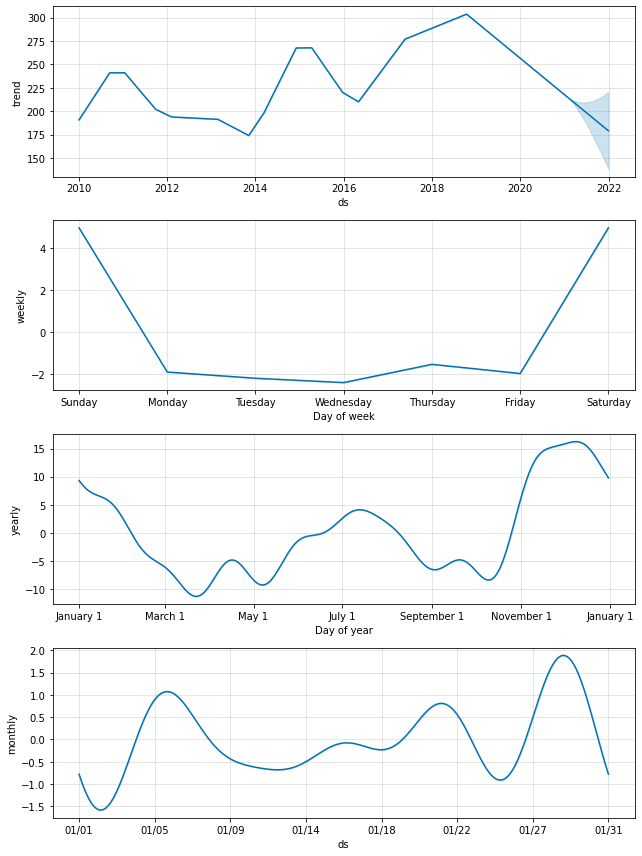

In [ ]:
model_prophet.plot_components(df_pred)

In [ ]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

In [ ]:
df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)

In [ ]:
import matplotlib.pyplot as plt

[Text(0, 0.5, 'Stock Price '),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Stock Price - actual vs. predicted')]

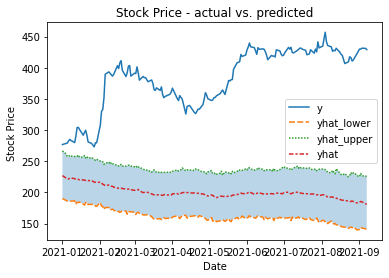

In [ ]:
fig, ax = plt.subplots(1, 1)
ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 'yhat_upper','yhat']])
ax.fill_between(df_test.index,
 df_test.yhat_lower,
 df_test.yhat_upper,
 alpha=0.3)
ax.set(title='Stock Price - actual vs. predicted',
 xlabel='Date',
 ylabel='Stock Price ')

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
def adf_test(x):
 indices = ['Test Statistic', 'p-value',
 '# of Lags Used', '# of Observations Used']
 adf_test = adfuller(x, autolag='AIC')
 results = pd.Series(adf_test[0:4], index=indices)
 for key, value in adf_test[4].items():
  results[f'Critical Value ({key})'] = value
 return results

In [ ]:
adf_test(df.y)

Test Statistic              -2.152640
p-value                      0.223881
# of Lags Used              17.000000
# of Observations Used    2862.000000
Critical Value (1%)         -3.432637
Critical Value (5%)         -2.862550
Critical Value (10%)        -2.567308
dtype: float64

In [ ]:
def kpss_test(x, h0_type='c'):
 indices = ['Test Statistic', 'p-value', '# of Lags']
 kpss_test = kpss(x, regression=h0_type)
 results = pd.Series(kpss_test[0:3], index=indices)
 for key, value in kpss_test[3].items():
  results[f'Critical Value ({key})'] = value
 return results

In [ ]:
kpss_test(df.y)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



Test Statistic            3.723934
p-value                   0.010000
# of Lags                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

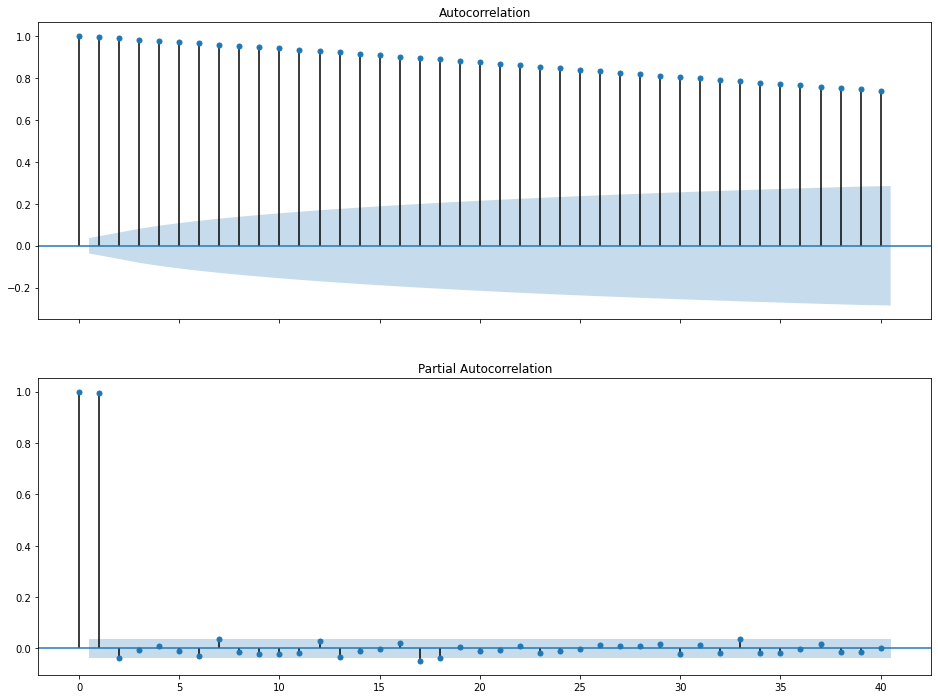

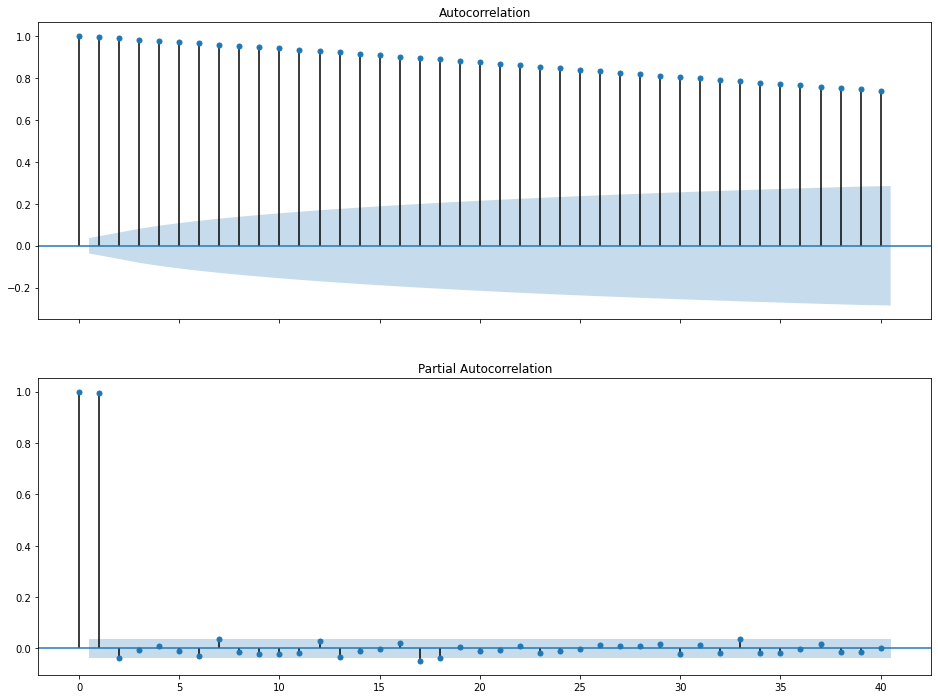

In [ ]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
plot_acf(df.y, ax=ax[0], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.y, ax=ax[1], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)